In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installer

In [ ]:
!pip install SimpleITK
!pip install pyradiomics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 40.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117

# **UNet**

**Import Necessary Packages**

In [ ]:
import os
import cv2
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

**Set Parameters**

In [ ]:
input_shape = (128, 128, 1)
batch_size = 16
epochs = 30
data_dir = '/content/drive/MyDrive/FYP/UNET/train'  # Path to your training data
model_path = '/content/drive/MyDrive/FYP/UNET/lung_segmentation_unet.h5'

# Utils

In [ ]:
def load_data(data_dir):
    images = []
    masks = []
    for filename in os.listdir(os.path.join(data_dir, 'images')):
        img = cv2.imread(os.path.join(data_dir, 'images', filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))  # Resize to desired size
        images.append(img)

        mask = cv2.imread(os.path.join(data_dir, 'masks', filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (128, 128))  # Resize to desired size
        masks.append(mask)

    images = np.array(images).astype('float32') / 255.0  # Normalize
    masks = np.array(masks).astype('float32') / 255.0  # Normalize
    masks = np.expand_dims(masks, axis=-1)  # Expand dims for channel

    return images, masks

In [ ]:
def get_data_splits(data_dir):
    images, masks = load_data(data_dir)
    return train_test_split(images, masks, test_size=0.2, random_state=42)

**Metrics**

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice coefficient for binary segmentation.

    Args:
    y_true (numpy.ndarray): Ground truth (true) binary mask.
    y_pred (numpy.ndarray): Predicted binary mask.
    smooth (float): Smoothing factor to avoid division by zero.

    Returns:
    float: Dice coefficient value.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + smooth)

In [ ]:
def iou(y_true, y_pred, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) for binary segmentation.

    Args:
    y_true (numpy.ndarray): Ground truth (true) binary mask.
    y_pred (numpy.ndarray): Predicted binary mask.
    smooth (float): Smoothing factor to avoid division by zero.

    Returns:
    float: IoU value.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    return intersection / (np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection + smooth)

In [ ]:
def pixel_accuracy(y_true, y_pred):
    """
    Compute pixel accuracy for binary segmentation.

    Args:
    y_true (numpy.ndarray): Ground truth (true) binary mask.
    y_pred (numpy.ndarray): Predicted binary mask.

    Returns:
    float: Pixel accuracy value.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.sum(y_true_flat == y_pred_flat) / y_true_flat.shape[0]

In [ ]:
def evaluate(y_true, y_pred):
    """
    Evaluate the segmentation performance using Dice, IoU, and Pixel Accuracy.

    Args:
    y_true (numpy.ndarray): Ground truth (true) binary mask.
    y_pred (numpy.ndarray): Predicted binary mask.

    Returns:
    dict: Dictionary containing evaluation metrics.
    """
    return {
        "Dice Coefficient": dice_coefficient(y_true, y_pred),
        "IoU": iou(y_true, y_pred),
        "Pixel Accuracy": pixel_accuracy(y_true, y_pred),
    }


In [ ]:
def unet(input_shape):
    inputs = layers.Input(input_shape)

    # Contracting Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Load Data**

In [ ]:
import os
import tensorflow as tf

# Assuming get_data_splits, unet, and other variables like model_path, batch_size, and epochs are defined elsewhere

X_train, X_val, y_train, y_val = get_data_splits(data_dir)

# Check if the saved model exists
if os.path.exists(model_path):
    # Load the saved model in TensorFlow's SavedModel format
    model = tf.keras.models.load_model(model_path)
    print(f"Loaded saved model from {model_path}")
else:
    # Create a U-Net model and train it
    input_shape = (128, 128, 1)  # Define input shape without batch dimension
    model = unet(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

    # Save the trained model in SavedModel format
    model.save(model_path)  # No .h5 extension to use SavedModel format
    print(f"Model saved to {model_path}")

Epoch 1/30
89/89 [==============================] - 223s 2s/step - loss: 0.1007 - accuracy: 0.9728 - val_loss: 0.0597 - val_accuracy: 0.9845
Epoch 2/30
89/89 [==============================] - 215s 2s/step - loss: 0.0721 - accuracy: 0.9834 - val_loss: 0.0547 - val_accuracy: 0.9845
Epoch 3/30
89/89 [==============================] - 215s 2s/step - loss: 0.0574 - accuracy: 0.9834 - val_loss: 0.0486 - val_accuracy: 0.9845
Epoch 4/30
89/89 [==============================] - 215s 2s/step - loss: 0.0464 - accuracy: 0.9834 - val_loss: 0.0408 - val_accuracy: 0.9845
Epoch 5/30
89/89 [==============================] - 215s 2s/step - loss: 0.0425 - accuracy: 0.9843 - val_loss: 0.0341 - val_accuracy: 0.9871
Epoch 6/30
89/89 [==============================] - 214s 2s/step - loss: 0.0344 - accuracy: 0.9866 - val_loss: 0.0303 - val_accuracy: 0.9878
Epoch 7/30
89/89 [==============================] - 216s 2s/step - loss: 0.0334 - accuracy: 0.9868 - val_loss: 0.0304 - val_accuracy: 0.9882
Epoch 8/30
89

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/FYP/UNET/lung_segmentation_unet.h5


**Prediction and Validation**

12/12 [==============================] - 9s 620ms/step


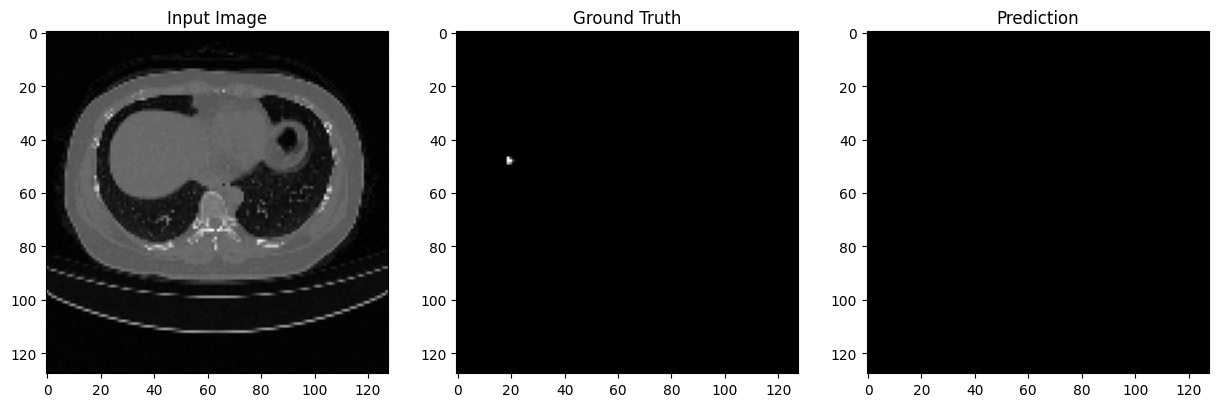

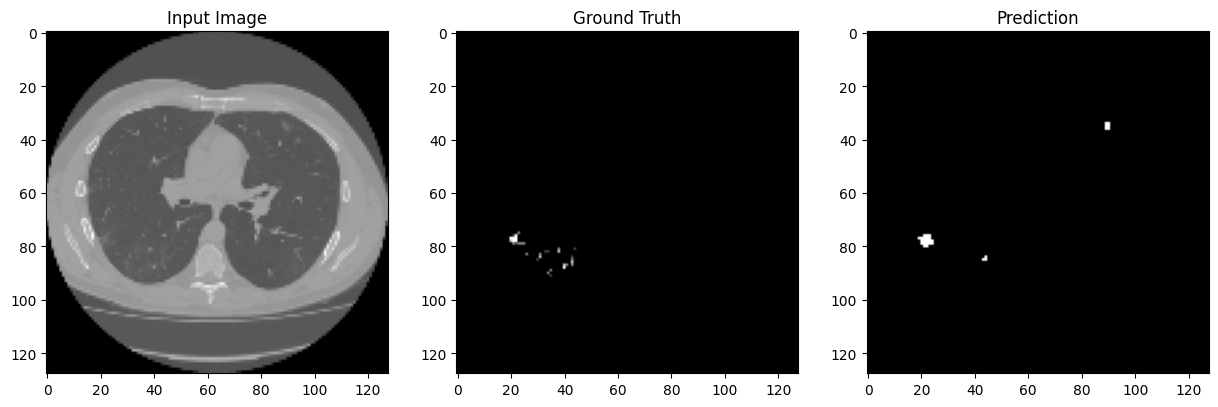

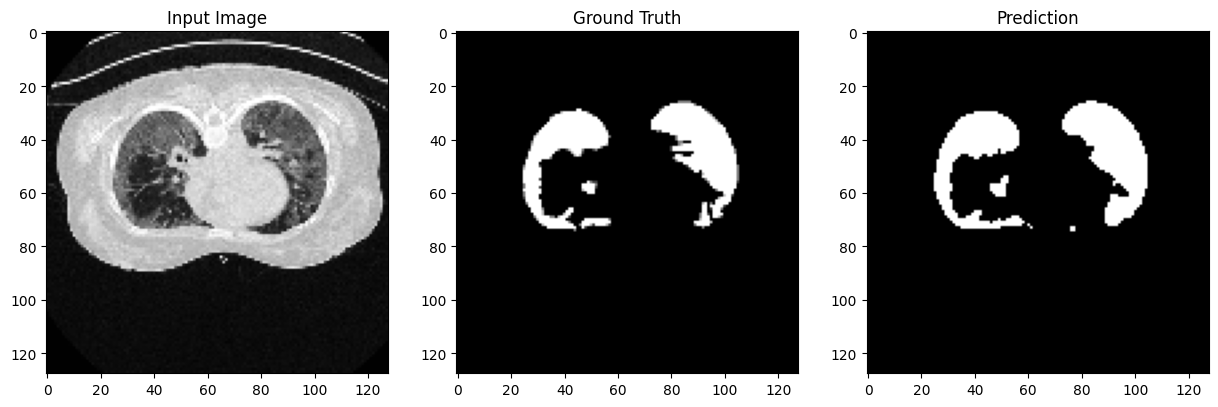

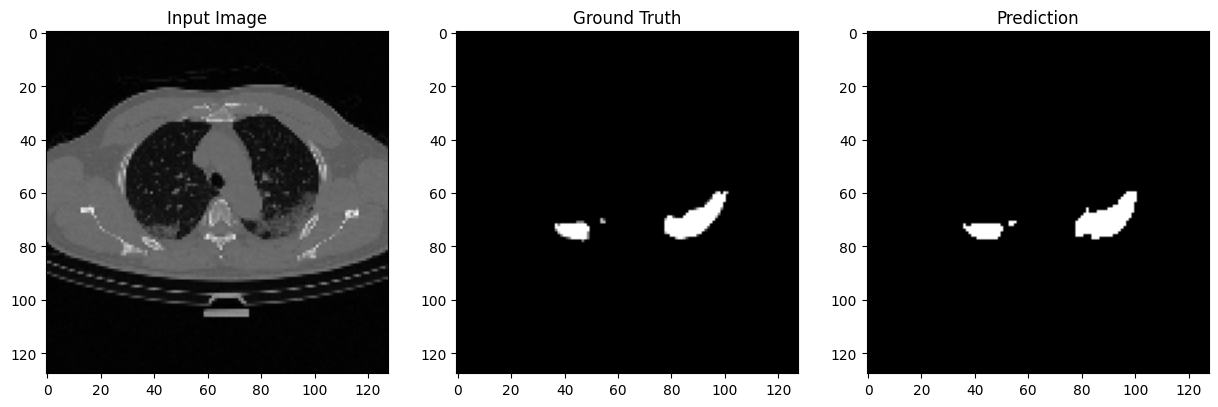

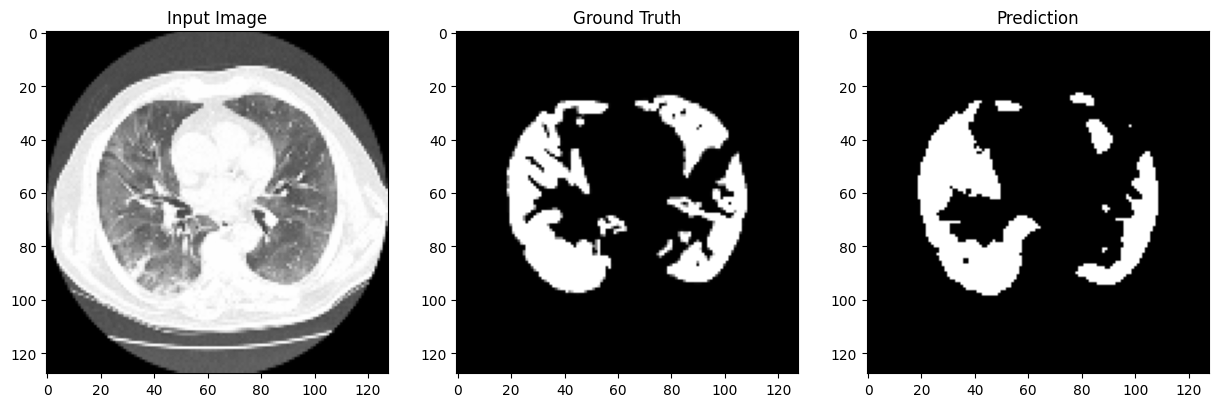

In [ ]:
# Make predictions on validation set
predictions = model.predict(X_val)

# Save the predictions
np.save('/content/drive/MyDrive/FYP/UNET/predictions.npy', predictions)

def visualize_predictions(X_val, y_val, predictions):
    thresholded_preds = (predictions > 0.5).astype(np.uint8)  # Threshold at 0.5
    for i in range(5):  # Display 5 samples
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(X_val[i].squeeze(), cmap='gray')
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(1, 3, 3)
        plt.imshow(thresholded_preds[i].squeeze(), cmap='gray')
        plt.title('Prediction')

        plt.show()

# Visualize the predictions
visualize_predictions(X_val, y_val, predictions)

# **Metrics**

In [ ]:
# After training, evaluate metrics
def evaluate_metrics(y_true, y_pred):
    dice = dice_coefficient(y_true, y_pred)
    iou_score = iou(y_true, y_pred)
    accuracy = pixel_accuracy(y_true, y_pred)
    print(f"Dice Coefficient: {dice}")
    print(f"IoU: {iou_score}")
    print(f"Pixel Accuracy: {accuracy}")

# Evaluate on validation set
evaluate_metrics(y_val, (predictions > 0.5).astype(np.uint8))

Dice Coefficient: 0.8207963167089352
IoU: 0.6960598311629862
Pixel Accuracy: 0.9935847567973164


**Training History**

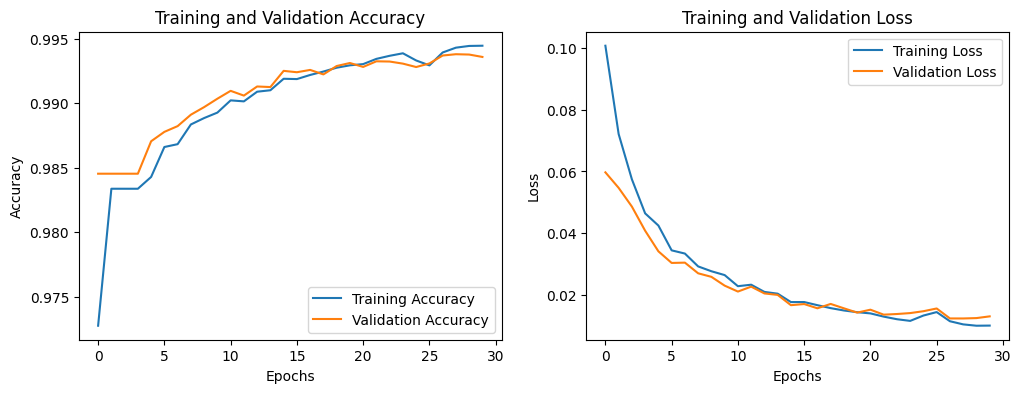

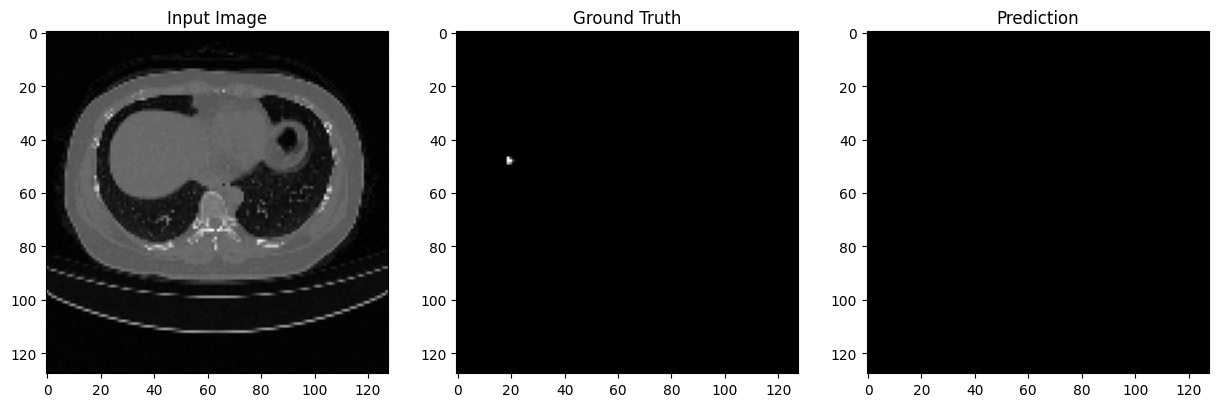

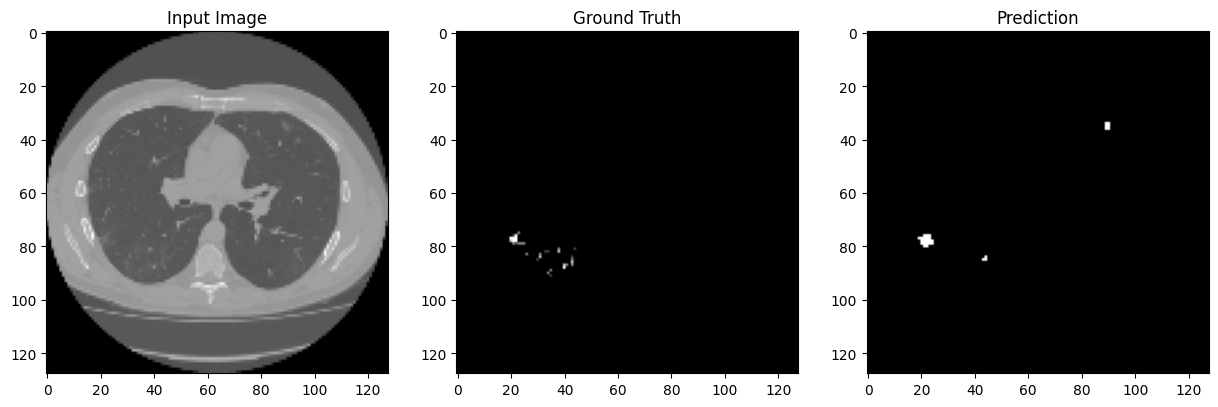

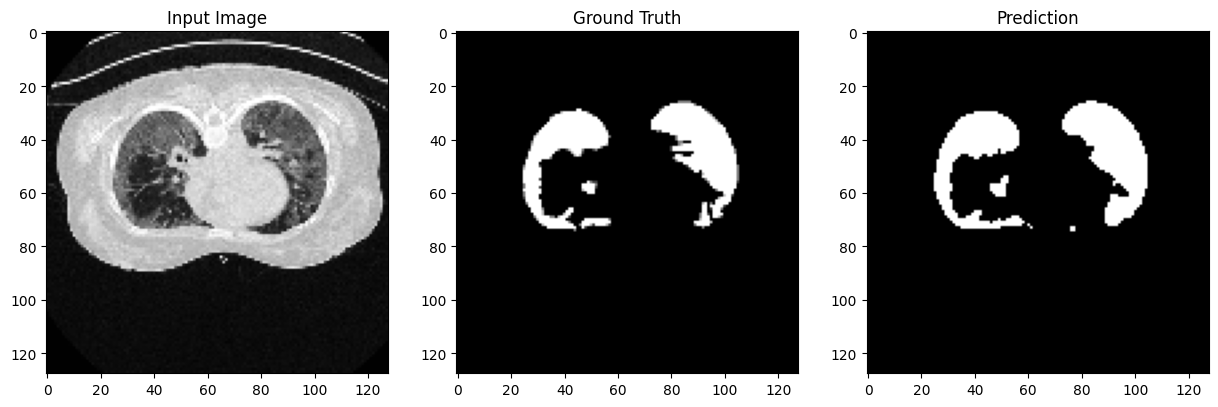

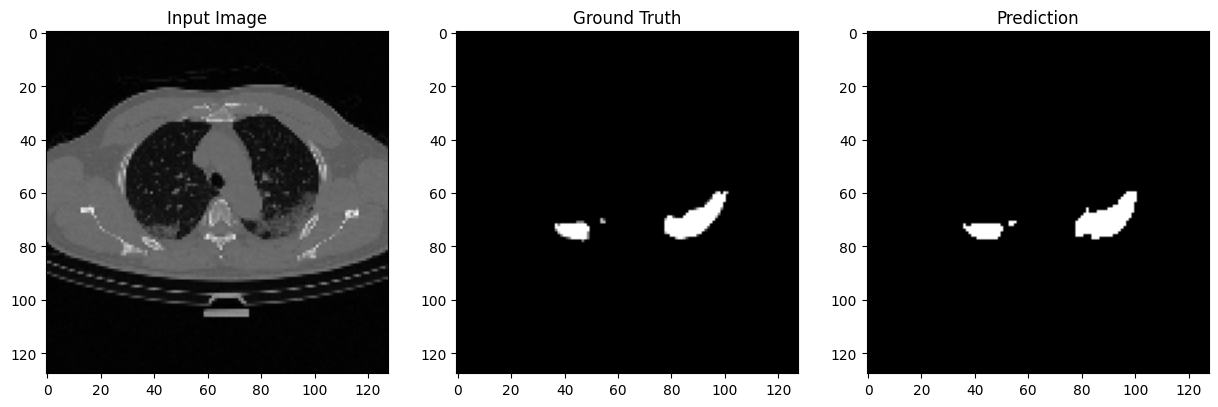

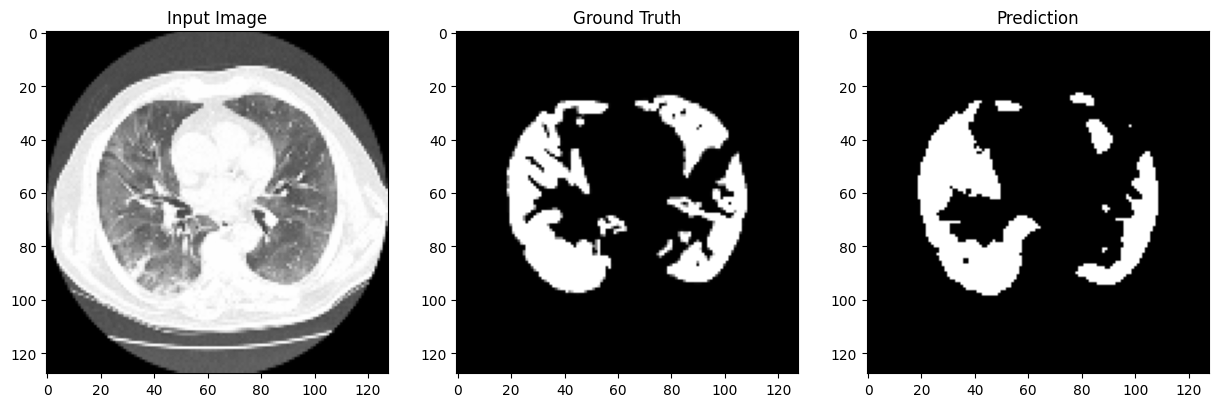

In [ ]:
# Plot training & validation accuracy and loss values over epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot the training history
if 'history' in locals():  # Make sure history exists from training
    plot_training_history(history)

# Visualize the predictions
visualize_predictions(X_val, y_val, predictions)